# Kaggle housing prices: Predicting prices of a new house based on the given data

### Borrows data exploration idea from the notebook on Kaggle by Pedro Marcelino

### Author: Sushant N. More

### Revision history: 
Sept. 8, 2017: started writing

Sept. 12, 2017: Merged from dev branch and cleaned the notebook

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import stats

from scipy.stats import shapiro
from scipy.stats import norm
from sklearn import preprocessing

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR

from sklearn.model_selection import cross_val_score

First step: look at the data

In [2]:
train_df = pd.read_csv('./data/train.csv')

In [3]:
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


That's a lot of features! 

In [4]:
train_df.columns.values

array(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir',
       'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea',
       'GarageQual', 'GarageCond', 'Pav

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

Few quick observations: Many null values (>~ 80%) for Alley, Fence, MiscFeature. 
Also about 50% null values for FireplaceQu

In [6]:
train_df.shape

(1460, 81)

In [7]:
test_df = pd.read_csv('./data/test.csv')

In [8]:
test_df.shape

(1459, 80)

In [9]:
test_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [10]:
test_df.columns.values

array(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir',
       'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea',
       'GarageQual', 'GarageCond', 'Pav

In [11]:
train_df.columns.values

array(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir',
       'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea',
       'GarageQual', 'GarageCond', 'Pav

test_df as expected does not have the SalesPrice data

Let's look at what the distribution of the SalesPrice.  Use the cool describe function

In [12]:
train_df['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Plotting the salesprice. More exploration of the distplot function in dev branch. 

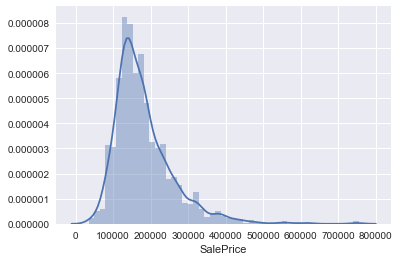

In [14]:
sns.distplot(train_df['SalePrice'], kde = True, norm_hist=True)

distplot combines the matplotlib hist function (with automatic calculation of a good default bin size) with the seaborn kdeplot() and rugplot() functions. It can also fit scipy.stats distributions and plot the estimated PDF over the data.

kdeplot
Show a univariate or bivariate distribution with a kernel density estimate.

rugplot
Draw small vertical lines to show each observation in a distribution.

We find that the distribution of the SalePrice has a long tail.  Not normally distributed.  To show off our statistics knowledge we use the Shapiro-Wilk test to see if the data is normally distributed.

In [15]:
shapiro(train_df['SalePrice'].values)

(0.869671642780304, 3.206247534576162e-33)

Since, the pvalue of Shapiro Wilk test is almost 0, we reject the Null hypothesis that the data was drawn from a normal distribution. 

Let's look at the skewness and kurtosis. 

Skewness is a measure of symmetry, or more precisely, the lack of symmetry. A distribution, or data set, is symmetric if it looks the same to the left and right of the center point.

Kurtosis is a measure of whether the data are heavy-tailed or light-tailed relative to a normal distribution. That is, data sets with high kurtosis tend to have heavy tails, or outliers. Data sets with low kurtosis tend to have light tails, or lack of outliers. A uniform distribution would be the extreme case.

Kurtosis of a standard normal distribution is 3. 

In [16]:
print "Skewness: %f" % train_df['SalePrice'].skew()
print "Kurtosis: %f" % train_df['SalePrice'].kurtosis()

Skewness: 1.882876
Kurtosis: 6.536282


** There are a ton of features here.  We will need to do some feature selection/ engineering.  Let's look at which features are the most correlated and which ones are the most relevant for the salesprice prediction ** 

In [17]:
corrmat = train_df.corr()

In [18]:
corrmat

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
Id,1.000000,0.011156,-0.010601,-0.033226,-0.028365,0.012609,-0.012713,-0.021998,-0.050298,-0.005024,...,-0.029643,-0.000477,0.002889,-0.046635,0.001330,0.057044,-0.006242,0.021172,0.000712,-0.021917
MSSubClass,0.011156,1.000000,-0.386347,-0.139781,0.032628,-0.059316,0.027850,0.040581,0.022936,-0.069836,...,-0.012579,-0.006100,-0.012037,-0.043825,-0.026030,0.008283,-0.007683,-0.013585,-0.021407,-0.084284
LotFrontage,-0.010601,-0.386347,1.000000,0.426095,0.251646,-0.059213,0.123349,0.088866,0.193458,0.233633,...,0.088521,0.151972,0.010700,0.070029,0.041383,0.206167,0.003368,0.011200,0.007450,0.351799
LotArea,-0.033226,-0.139781,0.426095,1.000000,0.105806,-0.005636,0.014228,0.013788,0.104160,0.214103,...,0.171698,0.084774,-0.018340,0.020423,0.043160,0.077672,0.038068,0.001205,-0.014261,0.263843
OverallQual,-0.028365,0.032628,0.251646,0.105806,1.000000,-0.091932,0.572323,0.550684,0.411876,0.239666,...,0.238923,0.308819,-0.113937,0.030371,0.064886,0.065166,-0.031406,0.070815,-0.027347,0.790982
OverallCond,0.012609,-0.059316,-0.059213,-0.005636,-0.091932,1.000000,-0.375983,0.073741,-0.128101,-0.046231,...,-0.003334,-0.032589,0.070356,0.025504,0.054811,-0.001985,0.068777,-0.003511,0.043950,-0.077856
YearBuilt,-0.012713,0.027850,0.123349,0.014228,0.572323,-0.375983,1.000000,0.592855,0.315707,0.249503,...,0.224880,0.188686,-0.387268,0.031355,-0.050364,0.004950,-0.034383,0.012398,-0.013618,0.522897
YearRemodAdd,-0.021998,0.040581,0.088866,0.013788,0.550684,0.073741,0.592855,1.000000,0.179618,0.128451,...,0.205726,0.226298,-0.193919,0.045286,-0.038740,0.005829,-0.010286,0.021490,0.035743,0.507101
MasVnrArea,-0.050298,0.022936,0.193458,0.104160,0.411876,-0.128101,0.315707,0.179618,1.000000,0.264736,...,0.159718,0.125703,-0.110204,0.018796,0.061466,0.011723,-0.029815,-0.005965,-0.008201,0.477493
BsmtFinSF1,-0.005024,-0.069836,0.233633,0.214103,0.239666,-0.046231,0.249503,0.128451,0.264736,1.000000,...,0.204306,0.111761,-0.102303,0.026451,0.062021,0.140491,0.003571,-0.015727,0.014359,0.386420


Gives a correlation matrix of numerical qualities

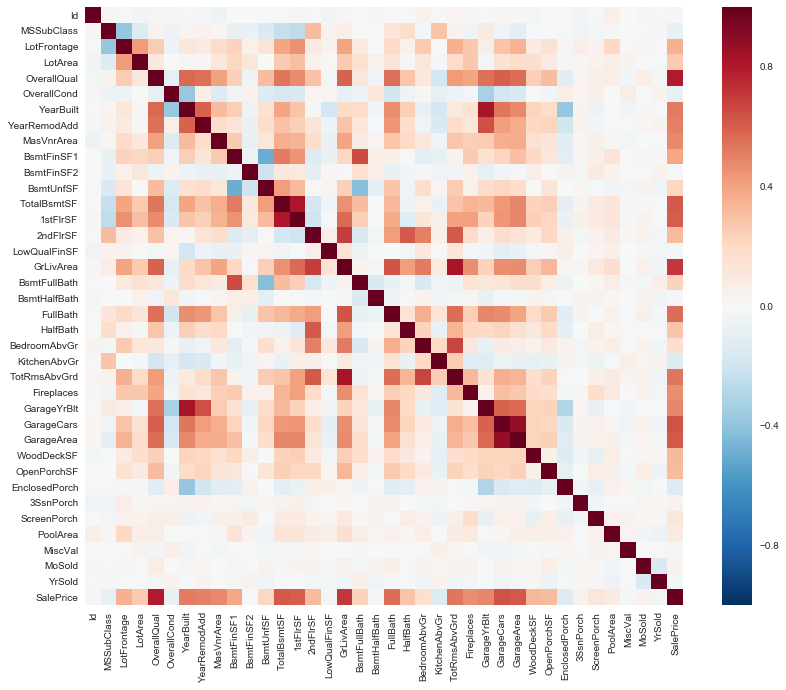

In [19]:
f, ax = plt.subplots(figsize = (14, 11))
sns.heatmap(corrmat, vmax = 1, square = True)

We find that the 'TotalBsmtSF' and '1stFlrSF' features are correlated.  Also find that all the Garage features are correlated.  Probably can do away with some of them in the spirit of getting rid of redundant features. 

From this plot we also find which features are most important for predicting the SalePrice.

Below, a nifty way to find out how many features belong to a particular category

In [20]:
train_df.select_dtypes(include = ['object']).columns

Index([u'MSZoning', u'Street', u'Alley', u'LotShape', u'LandContour',
       u'Utilities', u'LotConfig', u'LandSlope', u'Neighborhood',
       u'Condition1', u'Condition2', u'BldgType', u'HouseStyle', u'RoofStyle',
       u'RoofMatl', u'Exterior1st', u'Exterior2nd', u'MasVnrType',
       u'ExterQual', u'ExterCond', u'Foundation', u'BsmtQual', u'BsmtCond',
       u'BsmtExposure', u'BsmtFinType1', u'BsmtFinType2', u'Heating',
       u'HeatingQC', u'CentralAir', u'Electrical', u'KitchenQual',
       u'Functional', u'FireplaceQu', u'GarageType', u'GarageFinish',
       u'GarageQual', u'GarageCond', u'PavedDrive', u'PoolQC', u'Fence',
       u'MiscFeature', u'SaleType', u'SaleCondition'],
      dtype='object')

In [21]:
len(train_df.select_dtypes(include = ['object']).columns)

43

In [22]:
train_df.select_dtypes(include = ['float']).columns

Index([u'LotFrontage', u'MasVnrArea', u'GarageYrBlt'], dtype='object')

In [23]:
len(train_df.select_dtypes(include = ['float']).columns)

3

In [24]:
train_df.select_dtypes(include = ['int']).columns

Index([u'Id', u'MSSubClass', u'LotArea', u'OverallQual', u'OverallCond',
       u'YearBuilt', u'YearRemodAdd', u'BsmtFinSF1', u'BsmtFinSF2',
       u'BsmtUnfSF', u'TotalBsmtSF', u'1stFlrSF', u'2ndFlrSF', u'LowQualFinSF',
       u'GrLivArea', u'BsmtFullBath', u'BsmtHalfBath', u'FullBath',
       u'HalfBath', u'BedroomAbvGr', u'KitchenAbvGr', u'TotRmsAbvGrd',
       u'Fireplaces', u'GarageCars', u'GarageArea', u'WoodDeckSF',
       u'OpenPorchSF', u'EnclosedPorch', u'3SsnPorch', u'ScreenPorch',
       u'PoolArea', u'MiscVal', u'MoSold', u'YrSold', u'SalePrice'],
      dtype='object')

In [25]:
len(train_df.select_dtypes(include = ['int']).columns)

35

In [26]:
len(train_df.select_dtypes(include = ['int']).columns) + len(train_df.select_dtypes(include = ['float']).columns) \
+ len(train_df.select_dtypes(include = ['object']).columns)

81

Back to look at correlations

In [27]:
corrmat.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
Id,1.000000,0.011156,-0.010601,-0.033226,-0.028365,0.012609,-0.012713,-0.021998,-0.050298,-0.005024,...,-0.029643,-0.000477,0.002889,-0.046635,0.001330,0.057044,-0.006242,0.021172,0.000712,-0.021917
MSSubClass,0.011156,1.000000,-0.386347,-0.139781,0.032628,-0.059316,0.027850,0.040581,0.022936,-0.069836,...,-0.012579,-0.006100,-0.012037,-0.043825,-0.026030,0.008283,-0.007683,-0.013585,-0.021407,-0.084284
LotFrontage,-0.010601,-0.386347,1.000000,0.426095,0.251646,-0.059213,0.123349,0.088866,0.193458,0.233633,...,0.088521,0.151972,0.010700,0.070029,0.041383,0.206167,0.003368,0.011200,0.007450,0.351799
LotArea,-0.033226,-0.139781,0.426095,1.000000,0.105806,-0.005636,0.014228,0.013788,0.104160,0.214103,...,0.171698,0.084774,-0.018340,0.020423,0.043160,0.077672,0.038068,0.001205,-0.014261,0.263843
OverallQual,-0.028365,0.032628,0.251646,0.105806,1.000000,-0.091932,0.572323,0.550684,0.411876,0.239666,...,0.238923,0.308819,-0.113937,0.030371,0.064886,0.065166,-0.031406,0.070815,-0.027347,0.790982


In [28]:
corrmat.nlargest(9, 'SalePrice')['SalePrice']

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
Name: SalePrice, dtype: float64

DataFrame.nlargest(n, columns, keep='first').
Get the rows of a DataFrame sorted by the n largest values of columns.

In [29]:
#saleprice correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index

In [30]:
cols

Index([u'SalePrice', u'OverallQual', u'GrLivArea', u'GarageCars',
       u'GarageArea', u'TotalBsmtSF', u'1stFlrSF', u'FullBath',
       u'TotRmsAbvGrd', u'YearBuilt'],
      dtype='object')

In [31]:
cm = np.corrcoef(train_df[cols].values.T)

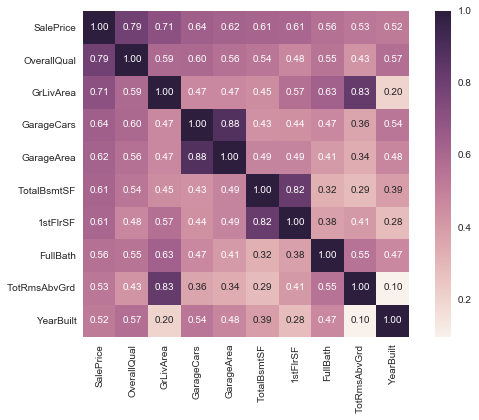

In [32]:
f, ax = plt.subplots(figsize = (9, 6))
sns.set(font_scale = 1)
sns.heatmap(cm, cbar = True, annot = True, square = True, fmt='.2f', \
            annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)

Looking at the column of SalePrice, we can see which are the features that it most heavily depends on. 

All we find that some of these feature (e.g., GarageCars and GarageArea, and TotalBsmtSF and 1stFlrSF) are interdependent -- "twin brothers".  We can get rid of one of those.

Let's look at some scatter plots

In [33]:
cols

Index([u'SalePrice', u'OverallQual', u'GrLivArea', u'GarageCars',
       u'GarageArea', u'TotalBsmtSF', u'1stFlrSF', u'FullBath',
       u'TotRmsAbvGrd', u'YearBuilt'],
      dtype='object')

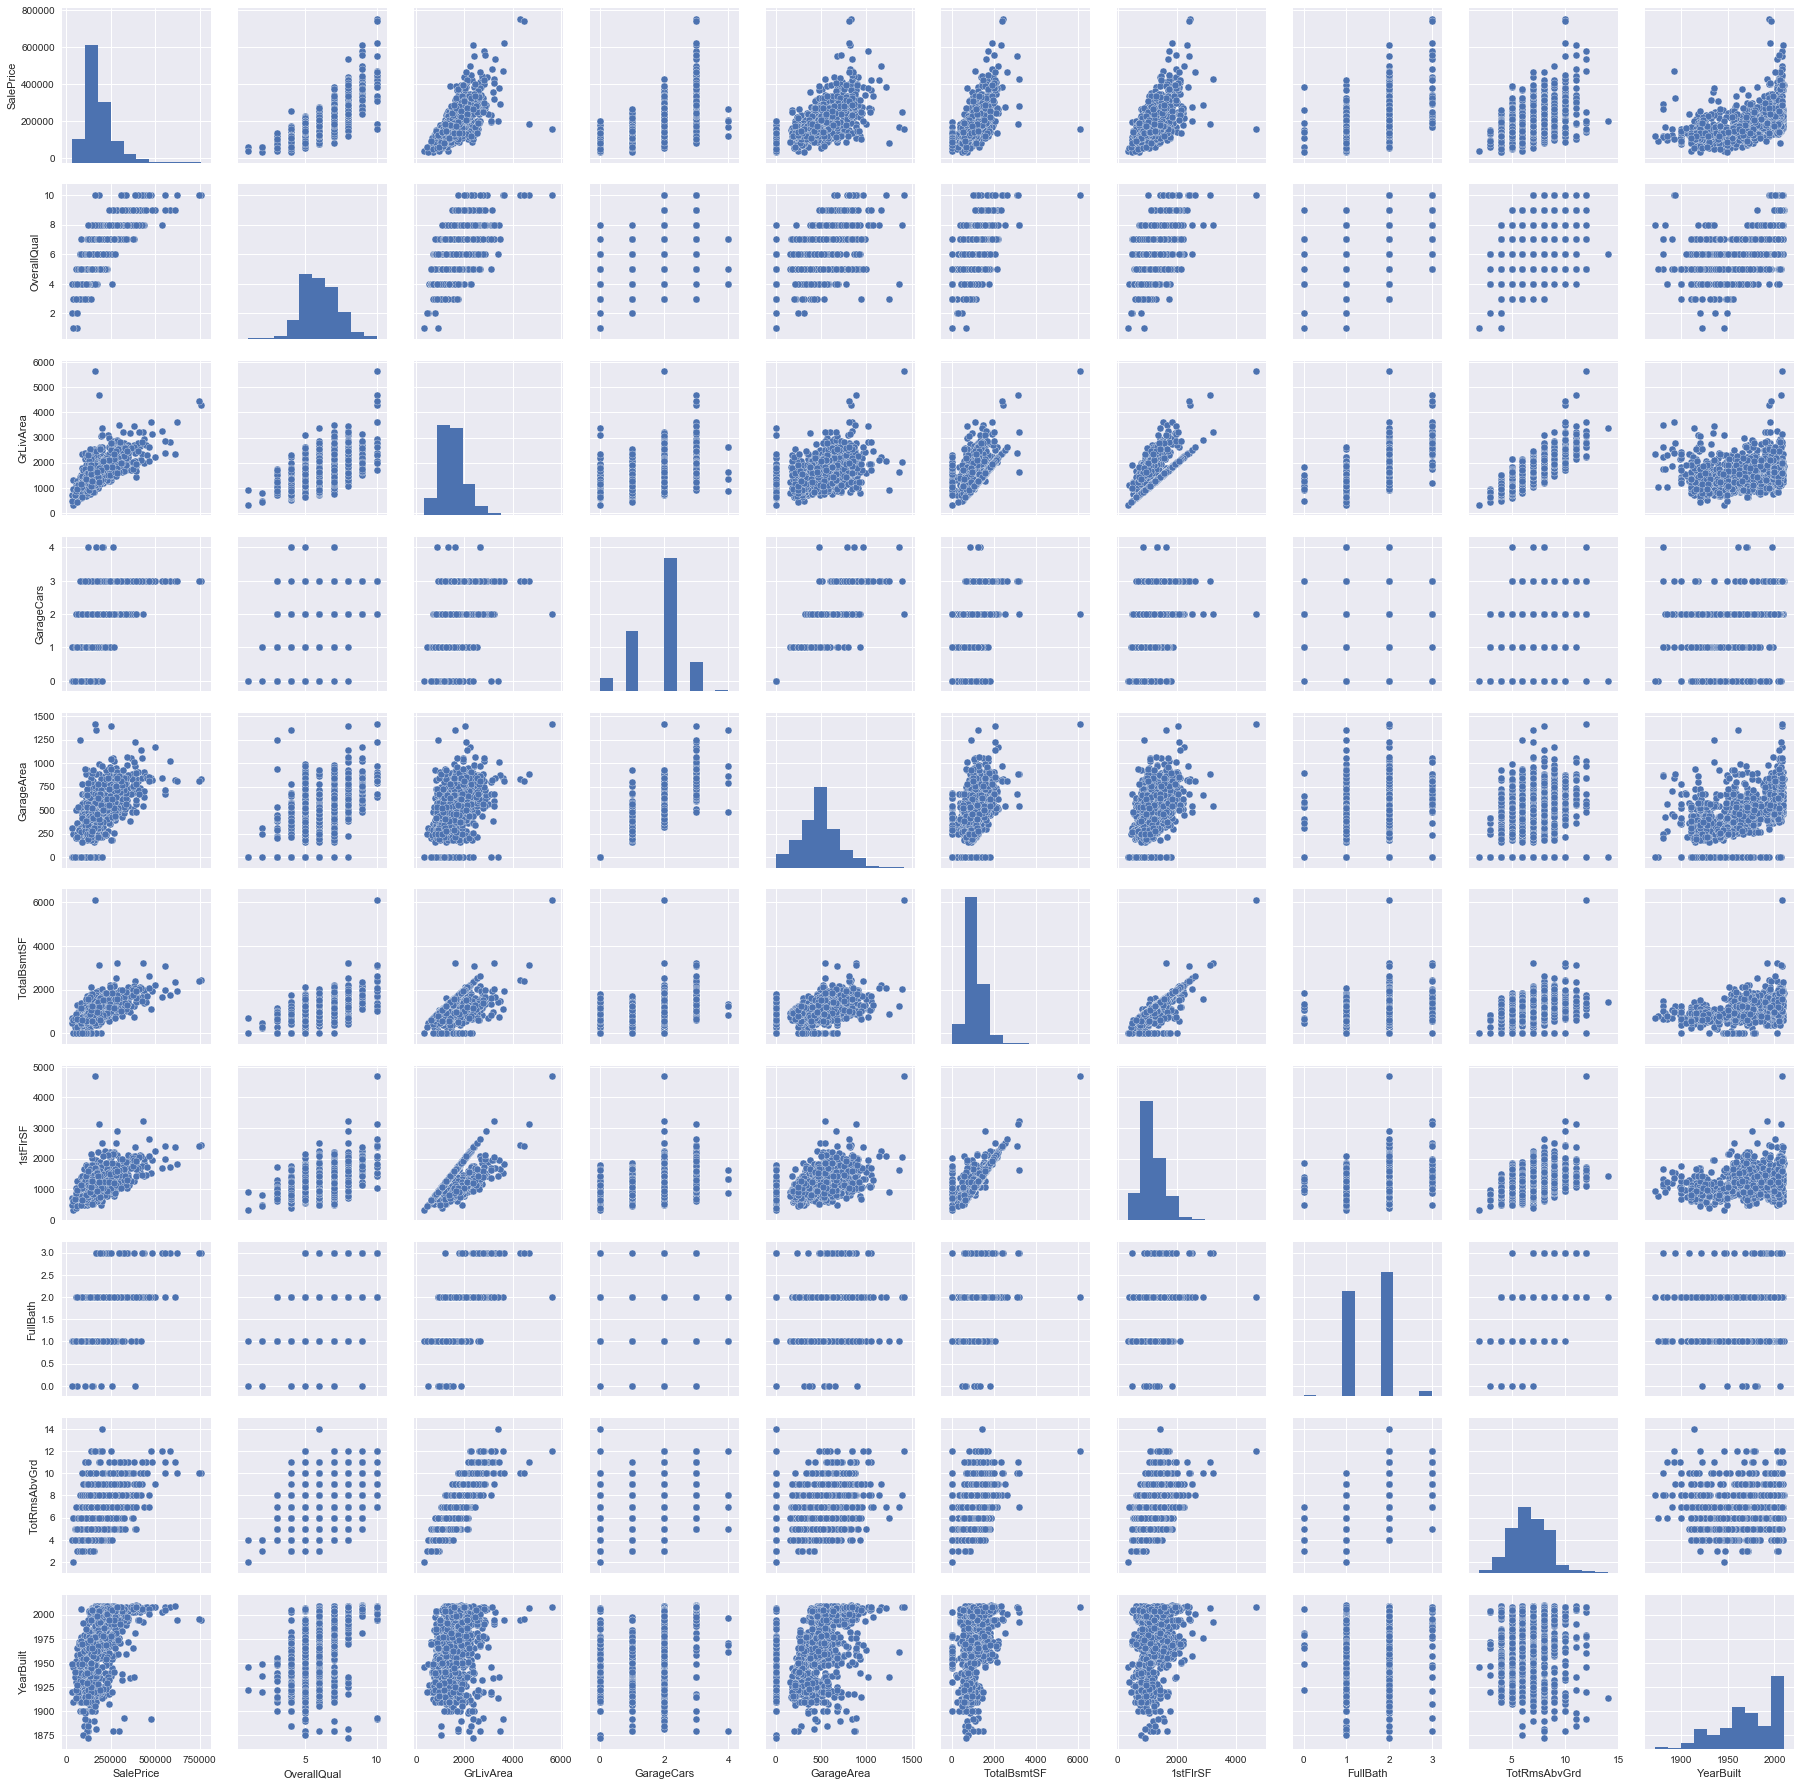

In [34]:
sns.pairplot(train_df[cols])

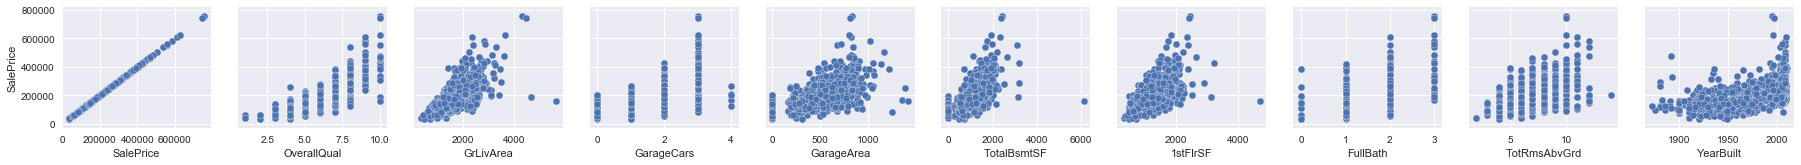

In [35]:
sns.pairplot(train_df[cols], x_vars = cols, y_vars = 'SalePrice', size = 2.5)

Let's look at some of the plots by themselves, starting with scatterplots for GrLiveArea and TotalBsmtSF

In [36]:
pd.concat([train_df.SalePrice, train_df.GrLivArea], axis = 1).head()

,SalePrice,GrLivArea
0,208500,1710
1,181500,1262
2,223500,1786
3,140000,1717
4,250000,2198


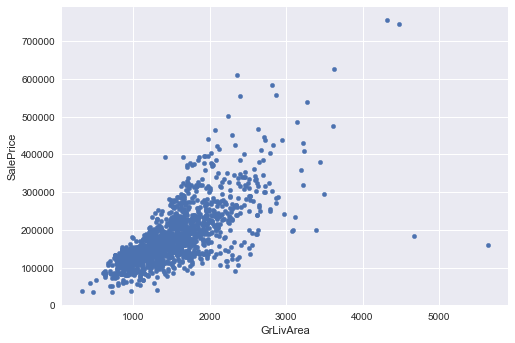

In [37]:
var = 'GrLivArea'
data = pd.concat([train_df['SalePrice'], train_df[var]], axis = 1)
data.plot.scatter(x = var, y = 'SalePrice')

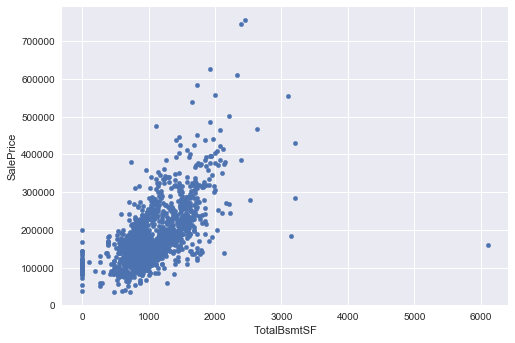

In [38]:
var = 'TotalBsmtSF'
data = pd.concat([train_df['SalePrice'], train_df[var]], axis = 1)
data.plot.scatter(x = var, y = 'SalePrice')

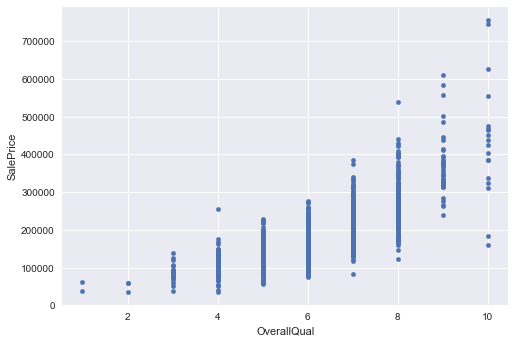

In [39]:
var = 'OverallQual'
data = pd.concat([train_df['SalePrice'], train_df[var]], axis = 1)
data.plot.scatter(x = var, y = 'SalePrice')

A better way to look at the categorical features is through box plot

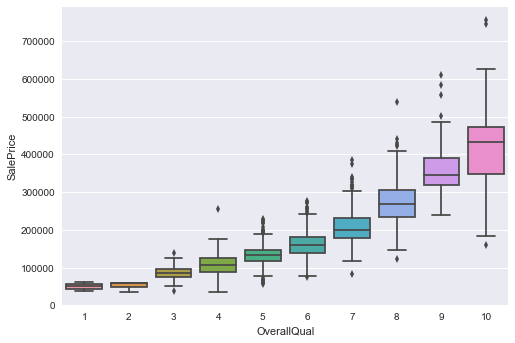

In [40]:
sns.boxplot(x = 'OverallQual', y = 'SalePrice', data=train_df)

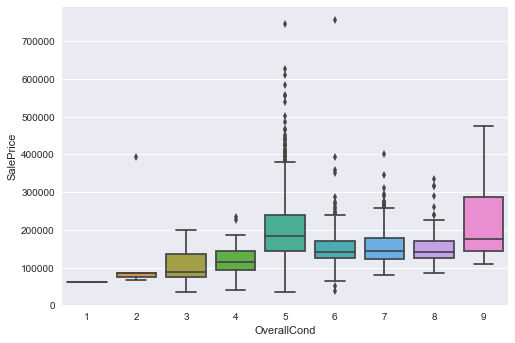

In [41]:
sns.boxplot(x = 'OverallCond', y = 'SalePrice', data=train_df)

The box shows the quartiles of the dataset while the whiskers extend to show the rest of the distribution, except for points that are determined to be “outliers” using a method that is a function of the inter-quartile range.

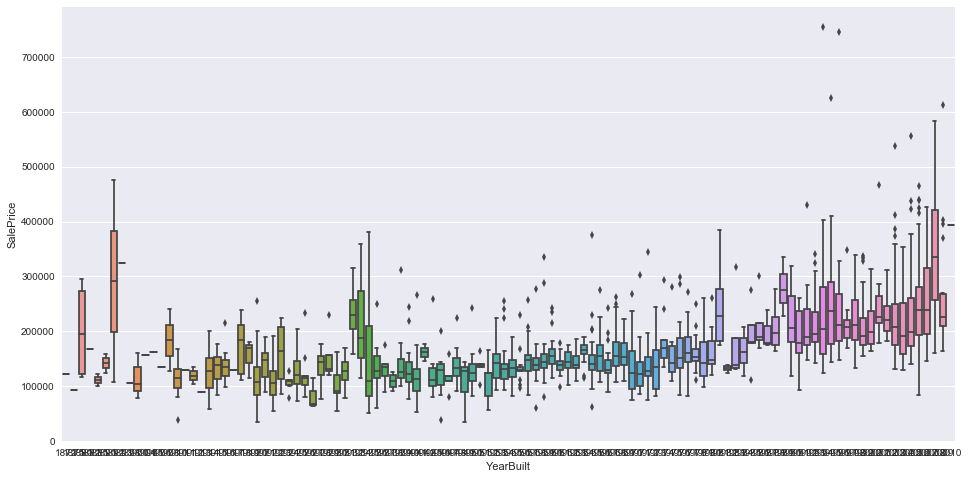

In [42]:
f, ax = plt.subplots(figsize=(16, 8))
sns.boxplot(x = 'YearBuilt', y = 'SalePrice', data=train_df)

In [43]:
np.sort(train_df.YearBuilt.values)

array([1872, 1875, 1880, ..., 2009, 2009, 2010])

In [44]:
np.sort(train_df.YearBuilt.unique())

array([1872, 1875, 1880, 1882, 1885, 1890, 1892, 1893, 1898, 1900, 1904,
       1905, 1906, 1908, 1910, 1911, 1912, 1913, 1914, 1915, 1916, 1917,
       1918, 1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928,
       1929, 1930, 1931, 1932, 1934, 1935, 1936, 1937, 1938, 1939, 1940,
       1941, 1942, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953,
       1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964,
       1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975,
       1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986,
       1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997,
       1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008,
       2009, 2010])

Conclusion: SalePrice definitely goes up with increasing GrLiveArea and TotalBsmtSF.  It only weakly goes up (if at all) with the YearBuilt 

## Taking care of missing data

In [ ]:
train_df.isnull().sum().sort_values(ascending = False).head(20)

In [ ]:
train_df.shape[0]

In [ ]:
total = train_df.isnull().sum().sort_values(ascending = False)
percent = train_df.isnull().sum().sort_values(ascending = False) / train_df.shape[0]
missingData = pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent missing'])
missingData.head(20)

In [ ]:
train_df.MasVnrArea.dtype

In [ ]:
train_df.MasVnrType.dtype

PoolQC, MiscFeature, Alley, Fence, and FireplaceQu have about 50% or more values missing.  No point in imputing.  Let's just drop these features.  Remember we gotta to drop the features from the test data as well so that later models are evaluated consistently

In [ ]:
total_test = test_df.isnull().sum().sort_values(ascending = False)
percent_test = test_df.isnull().sum().sort_values(ascending = False) / test_df.shape[0]
missingDataTest = pd.concat([total_test, percent_test], axis = 1, keys = ['Total', 'Percent missing'])
missingDataTest.head(35)

In [ ]:
missingData[missingData['Percent missing'] > 0.4].index

In [ ]:
combine_train_test = [train_df, test_df]

In [ ]:
train_df_mod = train_df.drop(missingData[missingData['Percent missing'] > 0.4].index, axis = 1)  
test_df_mod = test_df.drop(missingData[missingData['Percent missing'] > 0.4].index, axis = 1)

In [ ]:
train_df_mod.head()

We also saw before that GarageArea and GarageCars had a high correlation.  So did, TotalBsmtSF and 1stFlrSF. 

Let's look at the scatter plots before eliminating one of the twin brothers. 

In [ ]:
train_df_mod.plot.scatter(x = 'GarageArea', y = 'GarageCars')

In [ ]:
train_df_mod.plot.scatter(x = 'TotalBsmtSF', y = '1stFlrSF')

If there was not the line at y=0.  We could have eliminated one feature in the favor of another. Let's keep the features for now. Come back after the outliers are dealt with.  

In [ ]:
train_df_mod.plot.scatter(x = 'MoSold', y = 'SalePrice')

In [ ]:
train_df_mod.plot.scatter(x = 'OverallCond', y = 'SalePrice')

Let's look at the features which didn't contribute much to the salePrice and drop them.  As you can see, I am bent on dropping features

In [ ]:
corrmat = train_df.corr()

In [ ]:
corrmat.nlargest(81, 'SalePrice')['SalePrice']

In [ ]:
corr_values = corrmat.nlargest(81, 'SalePrice')['SalePrice']

In [ ]:
corr_values[(corr_values < 0.04) & (corr_values > - 0.03)]

In [ ]:
bad_features = corr_values[(corr_values < 0.04) & (corr_values > - 0.03)].index
bad_features

In [ ]:
bad_features = bad_features[bad_features != 'Id']

In [ ]:
bad_features

In [ ]:
train_df_mod2 = train_df_mod.drop(bad_features, axis = 1)

In [ ]:
test_df_mod2 = test_df_mod.drop(bad_features, axis = 1)

In [ ]:
train_df_mod2.head()

Let's again look at the missing values, with these dropped features

In [ ]:
total_test_mod2 = test_df_mod2.isnull().sum().sort_values(ascending = False)
percent_test_mod2 = test_df_mod2.isnull().sum().sort_values(ascending = False) / test_df_mod2.shape[0]
missingDataTest_mod2 = pd.concat([total_test_mod2, percent_test_mod2], axis = 1, \
                                 keys = ['Total', 'Percent missing'])
missingDataTest_mod2.head(30)

In [ ]:
total_train_mod2 = train_df_mod2.isnull().sum().sort_values(ascending = False)
percent_train_mod2 = train_df_mod2.isnull().sum().sort_values(ascending = False) / train_df_mod2.shape[0]
missingDataTrain_mod2 = pd.concat([total_train_mod2, percent_train_mod2], axis = 1, \
                                 keys = ['Total', 'Percent missing'])
missingDataTrain_mod2.head(20)

In [ ]:
train_df_mod2.loc[~train_df_mod2.GarageQual.isnull()][['Id', 'GarageCond', 'GarageQual', 'GarageType', \
                                                       'GarageYrBlt']]

We now know which variables have null values and need to be imputed.  Let's just look at them one by one.  Starting with the LotFrontage.  Let's start by seeing which other features are correlated with LotFrontage

In [ ]:
corrmat.nlargest(9, 'LotFrontage')['LotFrontage']

In [ ]:
train_df.plot.scatter(y = 'LotFrontage',  x = '1stFlrSF')

In [ ]:
train_df.plot.scatter(y = 'LotFrontage',  x = 'LotArea')

In [ ]:
train_df.plot.scatter(y = 'LotFrontage',  x = 'GrLivArea')

In [ ]:
plt.figure(figsize = (4,4))
plt.scatter(train_df['LotFrontage'], 0.9* np.sqrt(train_df['LotArea']))
plt.xlabel('LotFrontage')
plt.ylabel('0.9 * sqrt(LotArea)')

A good imputation strategy for LotFrontage is to replace it with 0.9 * \sqrt{LotArea}

In [ ]:
train_df_mod2.loc[train_df_mod2['LotFrontage'].isnull()].head()

In [ ]:
train_df_mod2.loc[train_df_mod2['LotFrontage'].isnull(), 'LotFrontage'] = 0.9 * np.sqrt(train_df_mod2['LotArea'])

In [ ]:
train_df_mod2.loc[7]

In [ ]:
test_df_mod2.loc[test_df_mod2['LotFrontage'].isnull(), 'LotFrontage'] = 0.9 * np.sqrt(test_df_mod2['LotArea'])

In [ ]:
total_train_mod2 = train_df_mod2.isnull().sum().sort_values(ascending = False)
percent_train_mod2 = train_df_mod2.isnull().sum().sort_values(ascending = False) / train_df_mod2.shape[0]
missingDataTrain_mod2 = pd.concat([total_train_mod2, percent_train_mod2], axis = 1, \
                                 keys = ['Total', 'Percent missing'])
missingDataTrain_mod2.head(15)

Below, trying to get a fill for values in the columns

In [ ]:
train_df_mod2['GarageCond'].unique()

In [ ]:
train_df_mod2['GarageQual'].unique()

In [ ]:
train_df_mod2['GarageType'].unique()

In [ ]:
train_df_mod2['GarageFinish'].unique()

In [ ]:
#train_df_mod2.plot.scatter(x = 'GarageCond', y = 'GarageQual')

In [ ]:
#sns.boxplot(x = 'GarageCond', y = 'GarageQual', data=train_df_mod2)

Scatter plot needs two X and Y values to be numerical, the boxplot needs at least one of the X, Y values to be numerical 

In [ ]:
train_df_mod2[['GarageCond', 'GarageQual', 'GarageType', 'GarageFinish', 'GarageYrBlt']].head(10)

In [ ]:
train_df_mod2.loc[train_df_mod2['GarageCond'].isnull()]\
[['GarageCond','GarageQual', 'GarageType', 'GarageFinish', 'GarageYrBlt', 'GarageCars', 'GarageArea']].head(7)

In [ ]:
sns.boxplot(x = 'GarageCond', y = 'SalePrice', data=train_df_mod2)

Can't say much about the SalePrice from looking at the Garage condition

In [ ]:
sns.boxplot(x = 'GarageQual', y = 'SalePrice', data=train_df_mod2)

In [ ]:
(train_df_mod2['GarageCond'].isnull() == train_df_mod2['GarageYrBlt'].isnull()).unique()

The data description file says that the NA value in Garage fields, means that the Garage doesn't exist.  

In [ ]:
combine_mod2 = [train_df_mod2, test_df_mod2]

In [ ]:
for dataset in combine_mod2:
    dataset['GarageType'] = dataset['GarageType'].fillna("No")
    dataset['GarageFinish'] = dataset['GarageFinish'].fillna("No")
    dataset['GarageQual'] = dataset['GarageQual'].fillna("No")
    dataset['GarageCond'] = dataset['GarageCond'].fillna("No")
    dataset['GarageArea'] = dataset['GarageArea'].fillna("0")
    dataset['GarageCars'] = dataset['GarageCars'].fillna("0")

In [ ]:
plt.scatter(train_df_mod2['GarageYrBlt'], train_df_mod2['YearBuilt'])
plt.xlabel('GarageYrBlt')
plt.ylabel('YearBuilt')

In [ ]:
sns.boxplot(x = 'GarageYrBlt', y = 'YearBuilt', data=train_df_mod2)

I've a feeling that setting the 'GarageYrBuilt' to 0 in the cases, where Garage is not there might be a bit hard on our learning algorithms.  In the cases that the Garage is absent, I'll just replace the 'GarageYrBuilt' with the year that house was built. 

In [ ]:
train_df_mod2.loc[train_df_mod2['GarageYrBlt'].isnull(), 'GarageYrBlt'] = train_df_mod2['YearBuilt']
test_df_mod2.loc[test_df_mod2['GarageYrBlt'].isnull(), 'GarageYrBlt'] = test_df_mod2['YearBuilt']

In [ ]:
total_train_mod2 = train_df_mod2.isnull().sum().sort_values(ascending = False)
percent_train_mod2 = train_df_mod2.isnull().sum().sort_values(ascending = False) / train_df_mod2.shape[0]
missingDataTrain_mod2 = pd.concat([total_train_mod2, percent_train_mod2], axis = 1, \
                                 keys = ['Total', 'Percent missing'])
missingDataTrain_mod2.head(10)

In [ ]:
total_test_mod2 = test_df_mod2.isnull().sum().sort_values(ascending = False)
percent_test_mod2 = test_df_mod2.isnull().sum().sort_values(ascending = False) / test_df_mod2.shape[0]
missingDataTest_mod2 = pd.concat([total_test_mod2, percent_test_mod2], axis = 1, \
                                 keys = ['Total', 'Percent missing'])
missingDataTest_mod2.head(20)

All the garage related null variables are taken care of.

In [ ]:
for dataset in combine_mod2:
    dataset['BsmtQual'] = dataset['BsmtQual'].fillna("No")
    dataset['BsmtCond'] = dataset['BsmtCond'].fillna("No")
    dataset['BsmtExposure'] = dataset['BsmtExposure'].fillna("No")
    dataset['BsmtFinType1'] = dataset['BsmtFinType1'].fillna("No")
    dataset['BsmtFinType2'] = dataset['BsmtFinType2'].fillna("No")
    dataset['BsmtFullBath'] = dataset['BsmtFullBath'].fillna(0)
    dataset['BsmtFinSF1'] = dataset['BsmtFinSF1'].fillna(0)
    dataset['BsmtUnfSF'] = dataset['BsmtUnfSF'].fillna(0)
    dataset['TotalBsmtSF'] = dataset['TotalBsmtSF'].fillna(0)

In [ ]:
train_df_mod2['TotalBsmtSF'].dtype

In [ ]:
train_df_mod2['BsmtUnfSF'].dtype

In [ ]:
train_df_mod2['BsmtFullBath'].dtype

In [ ]:
total_test_mod2 = test_df_mod2.isnull().sum().sort_values(ascending = False)
percent_test_mod2 = test_df_mod2.isnull().sum().sort_values(ascending = False) / test_df_mod2.shape[0]
missingDataTest_mod2 = pd.concat([total_test_mod2, percent_test_mod2], axis = 1, \
                                 keys = ['Total', 'Percent missing'])
missingDataTest_mod2.head(12)

In [ ]:
total_train_mod2 = train_df_mod2.isnull().sum().sort_values(ascending = False)
percent_train_mod2 = train_df_mod2.isnull().sum().sort_values(ascending = False) / train_df_mod2.shape[0]
missingDataTrain_mod2 = pd.concat([total_train_mod2, percent_train_mod2], axis = 1, \
                                 keys = ['Total', 'Percent missing'])
missingDataTrain_mod2.head(5)

All the basement related null variables are taken care of

In [ ]:
train_df_mod2['MasVnrType'].unique()

In [ ]:
train_df_mod2['MasVnrArea'].unique()[0:10]

In [ ]:
train_df_mod2.loc[train_df_mod2['MasVnrType'].isnull()][['MasVnrType', 'MasVnrArea']]

In [ ]:
test_df_mod2.loc[test_df_mod2['MasVnrType'].isnull()][['Id','MasVnrType', 'MasVnrArea']]

In [ ]:
test_df_mod2.loc[test_df_mod2['Id'] == 2611,'MasVnrType'] = 'BrkFace'

In [ ]:
test_df_mod2.loc[test_df_mod2['Id'] == 2611]['MasVnrType']

In [ ]:
test_df_mod2.loc[test_df_mod2['Id'] == 2611]['MasVnrArea']

In [ ]:
sns.boxplot(x = 'MasVnrType', y = 'MasVnrArea', data=train_df_mod2)

In [ ]:
train_df_mod2['MasVnrType'].value_counts()

Since, none is the mode, we replace the missing values for MasVnrType with None and the corresponding values for MasVnrArea with 0.  We make an exception for the entry in the test data which has a missing value for the MasVnrType and a value of 198 for MasVnrArea.  For that entry we set the MasVnrType to BrkFace, the second most common. 

In [ ]:
sns.distplot(train_df_mod2[train_df_mod2['MasVnrArea'].notnull()]['MasVnrArea'])

In [ ]:
for dataset in combine_mod2:
   
    dataset['MasVnrType'] = dataset['MasVnrType'].fillna('None')
    dataset['MasVnrArea'] = dataset['MasVnrArea'].fillna(0)
   

In [ ]:
total_test_mod2 = test_df_mod2.isnull().sum().sort_values(ascending = False)
percent_test_mod2 = test_df_mod2.isnull().sum().sort_values(ascending = False) / test_df_mod2.shape[0]
missingDataTest_mod2 = pd.concat([total_test_mod2, percent_test_mod2], axis = 1, \
                                 keys = ['Total', 'Percent missing'])
missingDataTest_mod2.head(8)

In [ ]:
total_train_mod2 = train_df_mod2.isnull().sum().sort_values(ascending = False)
percent_train_mod2 = train_df_mod2.isnull().sum().sort_values(ascending = False) / train_df_mod2.shape[0]
missingDataTrain_mod2 = pd.concat([total_train_mod2, percent_train_mod2], axis = 1, \
                                 keys = ['Total', 'Percent missing'])
missingDataTrain_mod2.head(5)

** Missing values in MasVnrArea and MasVnrType taken care of **

In [ ]:
train_df_mod2['Electrical'].value_counts()

In [ ]:
train_df_mod2['MSZoning'].value_counts()

In [ ]:
train_df_mod2['Functional'].value_counts()

In [ ]:
train_df_mod2['Utilities'].value_counts()

In [ ]:
train_df_mod2['Exterior2nd'].value_counts()

In [ ]:
train_df_mod2['Exterior1st'].value_counts()

In [ ]:
train_df_mod2['KitchenQual'].value_counts()

In [ ]:
train_df_mod2['SaleType'].value_counts()

Electrical, MSZoning, Functional, Utilities, Exterior2nd, Exterior1st, KitchenQual, SaleType all have one value which is much more prevalent than the other values.  So use that value to impute

In [ ]:
corrmatTry = train_df[['SalePrice', 'LotArea', 'OverallQual']].corr()

In [ ]:
corrmatTry

In [ ]:
np.corrcoef(train_df[['SalePrice', 'LotArea', 'OverallQual']].values.T)

In [ ]:
train_df[['SalePrice', 'LotArea']].values

In [ ]:
train_df[['SalePrice', 'LotArea']].values.T

In [ ]:
np.corrcoef(train_df[['SalePrice', 'LotArea']].values, rowvar = False)

In [ ]:
np.corrcoef(train_df[['SalePrice', 'LotArea', 'OverallQual']].values, rowvar = False)

numpy.corrcoef() and .corr() do the same thing.  The only difference is in numpy.corrcoef(), the default option for rowvar is True.  This means that it treats each row as a variable (feature) with the column values as observations

In [ ]:
test_df_mod2.loc[test_df_mod2['Utilities'].isnull()]

In [ ]:
#preprocessing.Imputer(strategy= 'most_frequent').fit(test_df_mod2.Utilities)

I'd have thought that the sklearn's imputer for the 'most_frequent' case would work with strings.  That doesn't seem to the same.  Just impute each feature by hand. 

In [ ]:
for dataset in combine_mod2:
   
    dataset['Electrical'] = dataset['Electrical'].fillna('SbrKr')
    dataset['MSZoning'] = dataset['MSZoning'].fillna('RL')
    dataset['Functional'] = dataset['Functional'].fillna('Typ')
    dataset['Utilities'] = dataset['Utilities'].fillna('AllPub')
    dataset['Exterior2nd'] = dataset['Exterior2nd'].fillna('VinylSd')
    dataset['Exterior1st'] = dataset['Exterior1st'].fillna('VinylSd')
    dataset['KitchenQual'] = dataset['KitchenQual'].fillna('TA')
    dataset['SaleType'] = dataset['SaleType'].fillna('WD')
    

In [ ]:
total_train_mod2 = train_df_mod2.isnull().sum().sort_values(ascending = False)
percent_train_mod2 = train_df_mod2.isnull().sum().sort_values(ascending = False) / train_df_mod2.shape[0]
missingDataTrain_mod2 = pd.concat([total_train_mod2, percent_train_mod2], axis = 1, \
                                 keys = ['Total', 'Percent missing'])
missingDataTrain_mod2.head(3)

In [ ]:
total_test_mod2 = test_df_mod2.isnull().sum().sort_values(ascending = False)
percent_test_mod2 = test_df_mod2.isnull().sum().sort_values(ascending = False) / test_df_mod2.shape[0]
missingDataTest_mod2 = pd.concat([total_test_mod2, percent_test_mod2], axis = 1, \
                                 keys = ['Total', 'Percent missing'])
missingDataTest_mod2.head(3)

All missing features taken care off

In [ ]:
train_df_mod2.isnull().sum().max()

In [ ]:
test_df_mod2.isnull().sum().max()

Confirming again that all missing values are taken care of.

## Dealing with outliers

In [ ]:
salepriceScaled = preprocessing.StandardScaler().fit_transform(train_df['SalePrice'][:,np.newaxis]);

In [ ]:
salepriceScaled

In [ ]:
train_df['SalePrice'].head()

In [ ]:
train_df['SalePrice'][np.newaxis, :]

In [ ]:
train_df['SalePrice'][:, np.newaxis]

The newaxis object can be used in all slicing operations to create an axis of length one. newaxis is an alias for ‘None’, and ‘None’ can be used in place of this with the same result.

In [ ]:
train_df['SalePrice'][:, None]

In [ ]:
preprocessing.StandardScaler().fit_transform(train_df['SalePrice'][:,np.newaxis])

In [ ]:
preprocessing.StandardScaler().fit(train_df['SalePrice'][:,np.newaxis]).mean_

In [ ]:
preprocessing.StandardScaler().fit(train_df['SalePrice'][:,np.newaxis]).std_

In [ ]:
preprocessing.StandardScaler().fit(train_df['SalePrice'][:,np.newaxis]).scale_

In [ ]:
salepriceScaled = preprocessing.StandardScaler().fit_transform(train_df['SalePrice'][:,np.newaxis])

In [ ]:
low_range = salepriceScaled[salepriceScaled[:,0].argsort()][:10] 
#keeping this line here just to show the use of argsort
low_range = np.sort(salepriceScaled[:, 0])[:10]

In [ ]:
high_range = np.sort(salepriceScaled[:, 0])[-10:]

In [ ]:
print('outer range (low) of the distribution:')
print(low_range)
print('\n outer range (high) of the distribution:')
print(high_range)

Everything seems to be all right in the low range. In the high range, the points 7.1 and 7.22 are a bit off.  To decide to keep or eliminate them we look at the scatter plot again!

Let's look at the scatter plot with the numerical quantity which has the highest correlation with the 'SalePrice'. 

In [ ]:
train_df_mod2.plot.scatter(x = 'GrLivArea', y = 'SalePrice')

We define the two points in the far right as outliers and delete them. 

In [ ]:
train_df_mod2.sort_values(by = 'GrLivArea', ascending = False)[:2]

In [ ]:
train_df_mod2[train_df_mod2['Id'] == 1299].index

In [ ]:
train_df_mod2.shape

In [ ]:
train_df_mod3 = train_df_mod2.drop(train_df_mod2[train_df_mod2['Id'] == 1299].index)

In [ ]:
train_df_mod3.shape

In [ ]:
train_df_mod2 = train_df_mod2.drop(train_df_mod2[train_df_mod2['Id'] == 1299].index)

In [ ]:
train_df_mod2 = train_df_mod2.drop(train_df_mod2[train_df_mod2['Id'] == 524].index)

In [ ]:
train_df_mod2.shape

### Statistics time

#### Normality

In [ ]:
sns.distplot(train_df_mod2['SalePrice'], fit=norm)

In [ ]:
stats.probplot(train_df_mod2['SalePrice'], plot=plt)

More proof that the SalePrice is not normally distributed.  

** In case of positive skewness, a log transformation usually makes the data (pseudo)-normally distributed.**

In [ ]:
train_df_mod2['SalePrice'] = np.log(train_df_mod2['SalePrice']) 

Let's look at the distplot and probplot again

In [ ]:
sns.distplot(train_df_mod2['SalePrice'], fit=norm)

In [ ]:
stats.probplot(train_df_mod2.SalePrice, plot = plt)

Much better! Remember, when we get out the predictions from ML algorithms, they will be for log of the houseprice.  We will have to exponentiate them before submitting the answers.

Let's look at the distribution of other features which have a high correlation with SalePrice. 

In [ ]:
stats.probplot((train_df_mod2['GrLivArea']), plot = plt)

In [ ]:
np.power(36, 1./2)

In [ ]:
stats.probplot(np.sqrt(train_df_mod2['GrLivArea']), plot = plt)

In [ ]:
stats.probplot(np.power(train_df_mod2['GrLivArea'], 1.0/3), plot = plt)

In [ ]:
sns.distplot(train_df_mod2['GrLivArea'], fit = norm)

In [ ]:
sns.distplot(np.power(train_df_mod2['GrLivArea'], 1./3), fit = norm)

For this variable let's just go with the cube-root transformation

In [ ]:
train_df_mod2['GrLivArea'] = np.power(train_df_mod2['GrLivArea'], 1.0/3) 

In [ ]:
test_df_mod2['GrLivArea'] = np.power(test_df_mod2['GrLivArea'], 1.0/3) 

In [ ]:
sns.distplot(train_df_mod2['GarageArea'], fit = norm)

In [ ]:
corrmat.nlargest(10,'SalePrice')['SalePrice']

In [ ]:
sns.distplot(train_df_mod2['GarageArea'], fit = norm)

In [ ]:
sns.distplot(train_df_mod2['TotalBsmtSF'], fit = norm)

To treat skewness in GarageArea and TotalBsmtSF, we need to address the problem that some houses do not have a Garage or Basement.  Create new features 'HasGarage' and 'HasBsmt' 

In [ ]:
train_df_mod2['HasBsmt'] = 0
test_df_mod2['HasBsmt'] = 0
train_df_mod2['HasGarage'] = 0
test_df_mod2['HasGarage'] = 0

In [ ]:
train_df_mod2.loc[train_df_mod2['GarageArea'] > 0, 'HasGarage'] = 1
train_df_mod2.loc[train_df_mod2['TotalBsmtSF'] > 0, 'HasBsmt'] = 1
test_df_mod2.loc[test_df_mod2['GarageArea'] > 0, 'HasGarage'] = 1
test_df_mod2.loc[test_df_mod2['TotalBsmtSF'] > 0, 'HasBsmt'] = 1

In [ ]:
# This does not work for some reason
#for dataset in combine_mod2:
#    dataset.loc[dataset['GarageArea'] > 0, 'HasGarage'] = 1
#    dataset.loc[dataset['TotalBsmtSF'] > 0, 'HasBsmt'] = 1

In [ ]:
train_df_mod2.loc[train_df_mod2['HasBsmt'] == 1]['TotalBsmtSF']

In [ ]:
train_df_mod2.shape

In [ ]:
sns.distplot(np.log(train_df_mod2[train_df_mod2['TotalBsmtSF'] > 0]['TotalBsmtSF']), fit = norm)

In [ ]:
sns.distplot(np.power(train_df_mod2[train_df_mod2['GarageArea'] > 0]['GarageArea'] , 1./12), fit = norm)

In [ ]:
sns.distplot((train_df_mod2[train_df_mod2['GarageArea'] >= 0]['GarageArea']), fit = norm)

Seems like it is difficult to get rid of skewness in GarageArea. So let's get rid of skewness in TotalBsmtSF and call it a day. 

In [ ]:
train_df_mod2.loc[train_df_mod2['HasBsmt'] == 1, 'TotalBsmtSF'] = np.log(train_df_mod2['TotalBsmtSF']) 

In [ ]:
test_df_mod2.loc[test_df_mod2['HasBsmt'] == 1, 'TotalBsmtSF'] = np.log(test_df_mod2['TotalBsmtSF']) 

I beleive the message is received, because it tries to take log even when the 'TotalBsmtSF' is 0.  However, this is not a problem because we only store the matrix elements when 'TotalBsmtSF' is != 0. 

In [ ]:
train_df_mod2.loc[train_df_mod2['HasBsmt'] == 1][['HasBsmt', 'TotalBsmtSF']].head()

In [ ]:
train_df['TotalBsmtSF'].head()

In [ ]:
np.log(856)

In [ ]:
test_df_mod2.loc[test_df_mod2['HasBsmt'] == 0][['HasBsmt', 'TotalBsmtSF']].head()

In [ ]:
train_df_mod2.loc[train_df_mod2['HasBsmt'] == 0][['HasBsmt', 'TotalBsmtSF']].head()

In [ ]:
sns.distplot(train_df_mod2.loc[train_df_mod2['HasBsmt'] == 1]['TotalBsmtSF'])

In [ ]:
sns.distplot(train_df_mod2['TotalBsmtSF'])

In [ ]:
sns.distplot(test_df_mod2['TotalBsmtSF'])

### Homoscedasticity

Homoscedasticity is said to be present, if data has same (similar?) variance around the regression line across the board --> Same variance around the regression line for all values of the predictor variable (X). 

#### Heteroscedasticity:  
If there are subpopulations that have different variabilities from others.  One particular example, the "expanding" cone when the two varaibles are plotted.  See for instance SalePrice and GrLivArea scatter plot way above. 
Heteroscedasticity can invalidate statistical tests of siginificance that assume that the modelling errors are uncorrelated and uniform.

#### some more jargon:
An independent variable, sometimes called an experimental or predictor variable, is a variable that is being manipulated in an experiment in order to observe the effect of a dependent variable, sometimes called an outcome variable.   

The best approach to test homoscedasticity for two metric variables is graphically. Departures from an equal dispersion are shown by such shapes as cones (small dispersion at one side of the graph, large dispersion at the opposite side) or diamonds (a large number of points at the center of the distribution).

Starting by 'SalePrice' and 'GrLivArea'...

In [ ]:
train_df_mod2.plot.scatter(x = 'GrLivArea', y = 'SalePrice')

Note how the plot above is an improvement over the plot below as far homoscedasticity is concerned. This is because of the log transformation.  Taking care of normality takes care of homoscedasticity. 

In [ ]:
train_df.plot.scatter(x = 'GrLivArea', y = 'SalePrice')

In [ ]:
plt.scatter(train_df_mod2[train_df_mod2['HasBsmt'] == 1]['TotalBsmtSF'], \
            train_df_mod2[train_df_mod2['HasBsmt'] == 1]['SalePrice'])
plt.xlabel('TotalBsmtSF')
plt.ylabel('SalePrice')

Homoscedasticity with resepct to TotalBsmtSF check. 

In [ ]:
plt.scatter(train_df_mod2[train_df_mod2['HasGarage'] == 1]['GarageArea'], \
            train_df_mod2[train_df_mod2['HasGarage'] == 1]['SalePrice'])
plt.xlabel('GarageArea')
plt.ylabel('SalePrice')

Interestingly enough, GarageArea and SalePrice don't deviate much from homoscedaasticity.  Even though GarageArea is not normally distributed.

In [ ]:
train_df_mod2['MasVnrType'].value_counts()

In [ ]:
train_df_mod4 = pd.get_dummies(train_df_mod2)

In [ ]:
train_df_mod4['GarageQual_Ex'].head()

In [ ]:
train_df_mod2['GarageQual'].head()

In [ ]:
train_df_mod4.head()

All right, I don't like what get_dummies does! It creates more features according to values of categorical variable.  LabelEncoder seems more appropriate to what we want to do.

In [ ]:
train_df_mod2.select_dtypes(include = ['object']).columns

In [ ]:
train_df_mod2.select_dtypes(include = ['object']).columns.shape

In [ ]:
train_df_mod2.select_dtypes(include = ['int64']).columns.shape

In [ ]:
train_df_mod2.select_dtypes(include = ['float64']).columns.shape

In [ ]:
le = preprocessing.LabelEncoder()

In [ ]:
train_df_mod2['SaleType'].unique()

In [ ]:
le.fit(train_df_mod2['SaleType'].unique())

In [ ]:
train_df_mod4.loc[:, 'SaleType'] = le.transform(train_df_mod2['SaleType'])

In [ ]:
train_df_mod4['SaleType'].head(14)

In [ ]:
train_df_mod2['SaleType'].head(14)

Let's apply LabelEncoding transformation to all columns at once. 

In [ ]:
train_df_mod4['SaleType'].dtype

In [ ]:
test_df_mod2.select_dtypes(include = ['object']).columns

In [ ]:
for col in train_df_mod2.select_dtypes(include = ['object']).columns:
    le.fit(train_df_mod2[col].unique())
    train_df_mod2.loc[:, col] = le.transform(train_df_mod2[col])

In [ ]:
for col in test_df_mod2.select_dtypes(include = ['object']).columns:
    le.fit(test_df_mod2[col].unique())
    test_df_mod2.loc[:, col] = le.transform(test_df_mod2[col])

In [ ]:
train_df_mod2.info()

In [ ]:
test_df_mod2.info()

Everything is either a a float or integer.  We are finally ready to apply ML algorithms!

## Fitting models

Starting with vanilla version random forest.  Not changing any parameters. 

In [ ]:
X_train = train_df_mod2.drop('SalePrice', axis = 1)
Y_train = train_df_mod2['SalePrice']

In [ ]:
RFR = RandomForestRegressor()
RFR.fit(X_train, Y_train)
accRFC = round(RFR.score(X_train, Y_train), 4)
accRFC

In [ ]:
RFR_predict_simple = RFR.predict(test_df_mod2)

In [ ]:
RFR_predict_simple

In [ ]:
RFR_actual_price = np.exp(RFR_predict_simple)

In [ ]:
RFR_actual_price

In [ ]:
submission_RFR_simple = pd.DataFrame({
    'Id':test_df_mod2.Id,
    'SalePrice': RFR_actual_price
})

In [ ]:
submission_RFR_simple.head()

In [ ]:
#submission_RFR_simple.to_csv('./predictions/randomForestRegressorMostBasic.csv', index = False)
# gives the score of 0.16196

Realized that I left the 'Id' feature.  It should obviously have no effect on the SalePrice, eggting rid of it

In [ ]:
train_df_mod2['Id'].head()

In [ ]:
test_df_mod2['Id'].head()

Dropping the 'Id' feature

In [ ]:
X_train = train_df_mod2.drop(['SalePrice', 'Id'], axis = 1)
Y_train = train_df_mod2['SalePrice']

In [ ]:
RFR = RandomForestRegressor()
RFR.fit(X_train, Y_train)
accRFC = round(RFR.score(X_train, Y_train), 4)
accRFC

In [ ]:
X_test = test_df_mod2.drop('Id', axis = 1)

In [ ]:
RFR_predict_simple = RFR.predict(X_test)

In [ ]:
RFR_predict_simple

In [ ]:
RFR_actual_price = np.exp(RFR_predict_simple)

In [ ]:
RFR_actual_price

In [ ]:
submission_RFR_simple = pd.DataFrame({
    'Id':test_df_mod2.Id,
    'SalePrice': RFR_actual_price
})

In [ ]:
submission_RFR_simple.head()

In [ ]:
#submission_RFR_simple.to_csv('./predictions/randomForestRegressorMostBasicDropID.csv', index = False)
# gives the score of 0.16569

Including Cross validation

In [ ]:
RFR = RandomForestRegressor(n_estimators=100, n_jobs = -1)
RFR.fit(X_train, Y_train)
cross_val_score(RFR, X_train, Y_train)

In [ ]:
RFR = RandomForestRegressor(n_estimators=100, \
                            n_jobs = -1)
RFR.fit(X_train, Y_train)
cross_val_score(RFR, X_train, Y_train)

In [ ]:
np.sort(RFR.feature_importances_)[::-1]

In [ ]:
coefRFR = pd.Series(RFR.feature_importances_, index = X_train.columns).sort_values()

In [ ]:
coefRFR.tail()

In [ ]:
coefRFR.tail(10).plot(kind = 'barh')

In [ ]:
corrmat.nlargest(9, 'SalePrice')['SalePrice']

In [ ]:
X_train.loc[:, RFR.feature_importances_ > 0.01].columns

In [ ]:
X_train.loc[:, RFR.feature_importances_ > 0.5].columns

In [ ]:
RFR_predict_CV = RFR.predict(X_test)

In [ ]:
RFR_predict_CV

In [ ]:
RFR_actual_price_CV = np.exp(RFR_predict_CV)

In [ ]:
RFR_actual_price_CV

In [ ]:
submission_RFR_CV = pd.DataFrame({
    'Id':test_df_mod2.Id,
    'SalePrice': RFR_actual_price_CV
})

In [ ]:
submission_RFR_CV.head()

In [ ]:
#submission_RFR_CV.to_csv('./predictions/randomForestRegressorMostBasicDropIDCrossValidation100trees.csv', index = False)
# gives the score of 0.15247

200 trees give a score of 0.15247, 100 trees give a score of 0.15433

Let's try gradient boosting

In [ ]:
GB = GradientBoostingRegressor(n_estimators=500, learning_rate=0.1, subsample= 0.85)
GB.fit(X_train, Y_train)
cross_val_score(GB, X_train, Y_train)

In [ ]:
GB = GradientBoostingRegressor(n_estimators=100, learning_rate=0.2, subsample= 0.8)
GB.fit(X_train, Y_train)
cross_val_score(GB, X_train, Y_train)

In [ ]:
GB = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber')
GB.fit(X_train, Y_train)
cross_val_score(GB, X_train, Y_train)

In [ ]:
GB = GradientBoostingRegressor(n_estimators=500, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber')
GB.fit(X_train, Y_train)
cross_val_score(GB, X_train, Y_train)

In [ ]:
coef = pd.Series(GB.feature_importances_, index = X_train.columns).sort_values(ascending = False)

In [ ]:
coef.head(12)

In [ ]:
coef.head(20) #with 3000 estimators

In [ ]:
GB_predict_CV = GB.predict(X_test)

In [ ]:
GB_predict_CV

In [ ]:
GB_actual_price_CV = np.exp(GB_predict_CV)

In [ ]:
GB_actual_price_CV

In [ ]:
submission_GB_CV = pd.DataFrame({
    'Id':test_df_mod2.Id,
    'SalePrice': GB_actual_price_CV
})

In [ ]:
submission_GB_CV.head()

In [ ]:
submission_GB_CV.to_csv('./predictions/GradientBoostingDropIDCrossValidation3000-0p05-huberRandDefault.csv', index = False)
# gives the score of 0.13249

100, 0.1, 0.8 gave a score of 0.14483 (the best, I've so far)

In [ ]:
GB.feature_importances_

In [ ]:
train_df.select_dtypes(include = ['object']).columns

In [ ]:
train_df[]

Support Vector Machines

In [ ]:
svr = SVR(C = 0.1)
svr.fit(X_train, Y_train)
cross_val_score(svr, X_train, Y_train)

In [ ]:
SV_predict_CV = svr.predict(X_test)

In [ ]:
SV_predict_CV

In [ ]:
SV_actual_price_CV = np.exp(SV_predict_CV)
SV_actual_price_CV

Looks like the Support Vector Machine doesn't work.  Most likely it is because the features we have here are mixed (combination of continuous and categorical values). 

In [ ]:
GB_actual_price_CV

Let's look at the prediction on the test set

In [ ]:
RFRpred = RFR.predict(X_train)
GBpred = GB.predict(X_train)

In [ ]:
# visualize predicted values versus true values
plt.scatter(Y_train, RFRpred, c='b', marker='x');
plt.scatter(Y_train, GBpred, c='r', marker='*');
plt.scatter(Y_train, Y_train, c='g', marker='+');
plt.xlabel('True House Prices');
plt.legend(('Random Forest', 'Gradient Boosting', 'True value'));